In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import os
import time
from abc import ABC, abstractmethod
from dataclasses import dataclass

# --- ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ ---
@dataclass
class TrainingParams:
    n_epochs: int
    n_train_points: int
    batch_size: int
    optimizer: any
    use_static_training_set: bool = False
    lambda_r: float = 1.0
    lambda_bc: float = None  
    lambda_ic: float = None
    use_grad_norm_weighting_scheme: bool = False
    grad_norm_weighting_freq :int = 25    # Частота обновления (в шагах градиентного спуска) скоростей обучения lambda.
                                          # Если частота 0, то схема взвешивания скоростей обучения не используется 
                                          # и лямбды не обновляются
                                          # Используется при обновлении лямбд: 
                                          # lambda_new = alpha * lambda_old + (1 − alpha) * lambda_new
    grad_norm_weighting_alpha: float = 0.9

class FormattedTable:
    @dataclass
    class _ColumnInfo:
        name: str
        width: int
        format_str: str
        left_border: str
        right_border: str

    @staticmethod
    def _verify_format_str(s: str) -> None:
        left = s.find('{')
        right = s.find('}')
        
        # 1. Check for exactly one '{' and one '}', and order
        if left == -1 or right == -1:
            raise ValueError("Format string must contain both '{' and '}' symbols.")
        if s.count('{') > 1 or s.count('}') > 1:
            raise ValueError("Format string must contain exactly one '{' and one '}'.")
        if left > right:
            raise ValueError("The '{' symbol must come before the '}' symbol.")
        
        # 2. Check for exactly one ':'
        if s.count(':') != 1:
            raise ValueError("Format string must contain exactly one ':' symbol.")
        
        colon = s.find(':')
        
        # 3. Check that ':' is between '{' and '}'
        if not (left < colon < right):
            raise ValueError("The ':' symbol must be inside the '{}' brackets.")

    def __init__(self, columns_info, n_rows=1):
        tmp = [None] * len(columns_info)
        for i in range(len(tmp)):
            # Название столбца
            name = columns_info[i][0]
            
            # Границы столбца
            s = columns_info[i][1]
            FormattedTable._verify_format_str(s)
            format_str = s
            left_border = s[:s.find('{')]
            right_border = s[s.find('}') + 1:]

            # Ширина столбца без его границ
            s = s[ s.find('{'): s.find('}') + 1 ]
            width = len(s.format(1))

            tmp[i] = FormattedTable._ColumnInfo(name, width, format_str, left_border, right_border)
        
        self.columns_info = tmp
        self.n_allocated_rows = n_rows
        self.n_rows = 0

        self.data = {col.name: np.empty(n_rows, dtype=object) for col in self.columns_info}

    def _extend(self):
        data = self.data
        for key in data:
            arr = data[key]
            extra = np.empty_like(arr)
            data[key] = np.concatenate((arr, extra))
        self.n_allocated_rows *= 2

    def _header_as_string(self) -> str:
        s = ""
        c = ""
        for x in self.columns_info:
            format_str = x.left_border + '{:>' + str(x.width) + 's}' + x.right_border
            s += format_str.format(x.name)

            c += x.left_border + '-' * x.width + x.right_border
        return s + '\n' + c.replace(" ", "-")
    
    def set_value(self, column_name: str, index: int, value: any) -> None:
        while index > self.n_allocated_rows - 1:
            self._extend()
        self.data[column_name][index] = value
        if self.n_rows < index + 1:
            self.n_rows = index + 1

    def row_as_string(self, i: int) -> str:
        if i + 1 > self.n_rows:
            ValueError(f"Row index out of bounds. You specified index {i:d}, but current table has maximum {self.n_rows} rows")
        data = self.data
        s = ''
        for col in self.columns_info:
            x = data[col.name][i]
            if x is None: tmp = 'None'
            elif np.isnan(x): tmp = 'nan'
            elif np.isinf(x): tmp = 'inf' 
            else: tmp = x
            if x is None or np.isnan(x) or np.isinf(x):
                fmt = col.left_border + '{:>' + str(col.width) + 's}' + col.right_border
            else:
                fmt = col.format_str
            s += fmt.format(tmp)
        return s
    
    def __str__(self):
        s = self._header_as_string() + '\n'
        for i in range(self.n_rows):
            s += self.row_as_string(i) + '\n'
        return s

def initialize_weights(model, scheme):
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            if scheme == 'naive':
                nn.init.normal_(layer.weight, mean=0.0, std=1.0)
                if layer.bias is not None:
                    nn.init.normal_(layer.bias, mean=0.0, std=1.0)
            elif scheme == 'glorot_uniform':
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            elif scheme == 'glorot_normal':
                nn.init.xavier_normal_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
            else:
                raise ValueError(f"{scheme} is an unknown scheme for weights initialization")

def sample_points_1D(bounds: list[float], n: int, scheme: str, sobol_engine: torch.quasirandom.SobolEngine = None) -> torch.Tensor:
    a, b = bounds

    if scheme == "equal":
        return torch.linspace(a, b, n + 2)[1:-1].unsqueeze(1)
    elif scheme == "uniform":
        return (b - a) * torch.rand(n, 1) + a
    elif scheme == "sobol":
        if sobol_engine is None or not isinstance(sobol_engine, torch.quasirandom.SobolEngine):
            raise ValueError("For 'sobol' scheme, a valid SobolEngine instance must be provided.")
        points = sobol_engine.draw(n)
        return (b - a) * points + a
    else:
        raise ValueError(f"Unknown collocation points sampling scheme '{scheme}'.")

class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)            

def compute_grad_theta_norm(model):
    grad_norm = 0.0
    for param in model.parameters():
        if param.grad is not None:
            grad_norm += param.grad.norm(2).item()**2
    return grad_norm ** 0.5

# --- КЛАСС ПОЛНОСВЯЗНОЙ НЕЙРОННОЙ СЕТИ С FOURIER FEATURE EMBEDDING ---
class MultilayerPerceptronWithFFE(nn.Module):
    def __init__(self, layer_sizes, init_scheme, activation_fn=nn.Tanh(), use_FFE=True, FFE_m=100, FFE_sigma=1.0):
        super().__init__()

        if use_FFE:
            # Создание матрицы B как часть модели. Добавление в state_dict, но не в список параметров,
            # чтобы оптимизатор не менял её коэффициенты во время обучения модели. Также при таком
            # подходе матрица будет перемещаться на GPU вместе со всей моделью
            self.register_buffer('B', torch.randn(FFE_m, layer_sizes[0]) * FFE_sigma)
            layer_sizes[0] = 2 * FFE_m
        self.use_FFE = use_FFE 

        layers = []
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(activation_fn)
        self.layers = nn.Sequential(*layers)

        initialize_weights(self, init_scheme)

    def forward(self, x):
        if self.use_FFE:
            Bx = torch.matmul(x, self.B.T)  # Shape (batch_size, m)
            embedding = torch.cat((torch.cos(Bx), torch.sin(Bx)), dim=-1)  # Shape (batch_size, 2 * m)
            return self.layers(embedding)
        else:
            return self.layers(x)

# --- ИЕРАРХИЯ КЛАССОВ ДЛЯ КРАЕВОЙ ЗАДАЧИ ---
class BVP(ABC):
    @abstractmethod
    def sample_domain(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor: pass
    
    @abstractmethod
    def get_res_domain(self, model, x: torch.Tensor) -> torch.Tensor: pass    # model в параметрах метода это, конечно, костыль, но другого адекватного решения, которое не потребует переделывать половину кода и вводить новые абстракции, я пока не нашёл
    
    @abstractmethod
    def u_exact(self, x:torch.Tensor) -> torch.Tensor: pass


# Имитация интерфейсов (как в Java) - полностью абстрактных классов. 
# В Java один класс может наследоваться только от одного другого класса (унарное наследование) и от произвольного количества интерфейсов. 
# Интерфейсы в Java решают проблемы множественного наследования
class ISpatial(ABC):
    @property
    @abstractmethod
    def spatial_domain(self) -> list[float]: pass
    
    @abstractmethod
    def sample_bc(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor: pass

    @abstractmethod
    def get_res_bc(self, model, x: torch.Tensor) -> torch.Tensor: pass

class ITemporal(ABC):
    @property
    @abstractmethod
    def temporal_domain(self) -> list[float]: pass

    @abstractmethod
    def sample_ic(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor: pass

    # Возвращает кортеж с двумя тензорами. Первый - это вычет начального условия u = f(x), где x принадлежит границе.
    # Второй - это вычет начального условия du/dt(x) = g(x)
    @abstractmethod
    def get_res_ic(self, model, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]: pass

# --- КЛАСС-ТРЕНЕР НЕЙРОННОЙ СЕТИ ---
# TODO: сделать полиморфным, то есть чтобы мог работать с задачами, зависящими от времени
class Coach():
    def __init__(self, model, problem_obj):
        self.model = model
        self.problem_obj = problem_obj

    def update(self, x_domain, x_bc, x_ic, optimizer, lambda_r=1.0, lambda_bc=1.0, lambda_ic=1.0, grad_norm_weighting_alpha=0.9, update_lambda=False):
        model = self.model
        problem = self.problem_obj
        is_spatial = isinstance(problem, ISpatial)
        is_time_dependent = isinstance(problem, ITemporal)

        optimizer.zero_grad()
        loss_r = torch.mean((problem.get_res_domain(model, x_domain))**2)
        loss_r.backward(retain_graph=True)
        grad_loss_r_theta_norm = compute_grad_theta_norm(model)

        if is_spatial:
            optimizer.zero_grad()
            loss_bc = torch.mean((problem.get_res_bc(model, x_bc))**2)
            loss_bc.backward(retain_graph=True)
            grad_loss_bc_theta_norm = compute_grad_theta_norm(model)

        if is_time_dependent:
            optimizer.zero_grad()
            res_ic1, res_ic2 = problem.get_res_ic(model, x_ic)
            loss_ic = torch.mean(res_ic1**2) + torch.mean(res_ic2**2)
            loss_ic.backward(retain_graph=True)
            grad_loss_ic_theta_norm = compute_grad_theta_norm(model)

        if update_lambda:
            tmp = grad_loss_r_theta_norm
            if is_spatial: tmp += grad_loss_bc_theta_norm
            if is_time_dependent: tmp += grad_loss_ic_theta_norm

            alpha = grad_norm_weighting_alpha
            lambda_r_new = tmp / grad_loss_r_theta_norm
            lambda_r = alpha*lambda_r + (1.0 - alpha)*lambda_r_new
            if is_spatial: 
                lambda_bc_new = tmp / grad_loss_bc_theta_norm
                lambda_bc = alpha*lambda_bc + (1.0 - alpha)*lambda_bc_new
            if is_time_dependent: 
                lambda_ic_new = tmp / grad_loss_ic_theta_norm
                lambda_ic = alpha*lambda_ic + (1.0 - alpha)*lambda_ic_new
            
        loss = lambda_r * loss_r
        if is_spatial: loss += lambda_bc * loss_bc
        if is_time_dependent: loss += lambda_ic * loss_ic
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return (loss, loss_r, loss_bc if is_spatial else None, loss_ic if is_time_dependent else None, 
                lambda_r, lambda_bc if is_spatial else None, lambda_ic if is_time_dependent else None)

    def train(self, training_params):
        model = self.model
        device = next(model.parameters()).device
        problem = self.problem_obj
        is_spatial = isinstance(problem, ISpatial)
        is_time_dependent = isinstance(problem, ITemporal)

        n_epochs =                       training_params.n_epochs
        n_train_points =                 training_params.n_train_points
        batch_size =                     training_params.batch_size
        optimizer =                      training_params.optimizer
        use_static_training_set =        training_params.use_static_training_set
        lambda_r =                       training_params.lambda_r
        lambda_bc =                      training_params.lambda_bc
        lambda_ic =                      training_params.lambda_ic
        use_grad_norm_weighting_scheme = training_params.use_grad_norm_weighting_scheme
        grad_norm_weighting_freq =       training_params.grad_norm_weighting_freq
        grad_norm_weighting_alpha =      training_params.grad_norm_weighting_alpha
        if lambda_bc is None and is_spatial:
            raise ValueError("For solving a boundary value problem with spatial componets, a valid lambda_bc value must be provided.")
        if lambda_ic is None and is_time_dependent:
            raise ValueError("For solving a non-static boundary value problem, a valid lambda_ic value must be provided.")

        n_grad_steps = n_epochs * (n_train_points // batch_size)
        tm = FormattedTable(    # trainging metrics
            columns_info=[
                ("Epoch",          '{:6d} | '),
                ("loss",           '{:10.4e}   '),
                ("lambda_r",       '{:10.4e}   '),
                ("loss_r",         '{:10.4e}   '),
                ("lambda_bc",      '{:10.4e}   '),
                ("loss_bc",        '{:10.4e}   '),
                ("lambda_ic",      '{:10.4e}   '),
                ("loss_ic",        '{:10.4e} | '),
                ("err_r_l2",       '{:10.4e}   '),
                ("err_r_inf",      '{:10.4e}   '),
                ("err_bc_l2",      '{:10.4e}   '),
                ("err_bc_inf",     '{:10.4e}   '),
                ("err_ic_l2",      '{:10.4e}   '),
                ("err_ic_inf",     '{:10.4e} | '),
                ("rel_err_r_l2",   '{:12.2f}   '),
                ("rel_err_r_inf",  '{:13.2f}   '),
                ("rel_err_bc_l2",  '{:13.2f}   '),
                ("rel_err_bc_inf", '{:14.2f}   '),
                ("rel_err_ic_l2",  '{:13.2f}   '),
                ("rel_err_ic_inf", '{:14.2f} | '),
                ("res_r_l2",       '{:10.4e}   '),
                ("res_r_inf",      '{:10.4e}   '),
                ("res_bc_l2",      '{:10.4e}   '),
                ("res_bc_inf",     '{:10.4e}   '),
                ("res_ic_l2",      '{:10.4e}   '),
                ("res_ic_inf",     '{:10.4e} | '),
                ("time, sec",      '{:10.2f}')
            ],
            n_rows=n_grad_steps
        )

        # Тестовые данные
        x_test_domain = problem.sample_domain(n=n_train_points, device=device)
        u_test_domain = problem.u_exact(x_test_domain).to('cpu')
        if is_spatial:
            x_test_bc = problem.sample_bc(n=n_train_points, device=device)
            u_test_bc = problem.u_exact(x_test_bc).to('cpu')
        else:
            x_test_bc = torch.tensor([[-1.0]])
            u_test_bc = torch.tensor([[-1.0]])
        if is_time_dependent:
            x_test_ic = problem.sample_ic(n=n_train_points, device=device)
            u_test_ic = problem.u_exact(x_test_ic).to('cpu')
        else:
            x_test_ic = torch.tensor([[-1.0]])
            u_test_ic = torch.tensor([[-1.0]])

        print( tm._header_as_string() )
        training_start_time = time.time()
        gs = -1    # gradient step number
        for epoch in range(n_epochs):
            epoch_start_time = time.time()
            if epoch == 0 or not use_static_training_set:
                x_train_domain = problem.sample_domain(n=n_train_points, device=device)
                if is_spatial: x_train_bc = problem.sample_bc(n=n_train_points, device=device)
                if is_time_dependent: x_train_ic = problem.sample_ic(n=n_train_points, device=device)
                update_lambda = False

            for i in range(0, n_train_points, batch_size):
                gs += 1
                if use_grad_norm_weighting_scheme:
                    update_lambda = True if (gs + 1) % grad_norm_weighting_freq == 0 else False
                
                loss, loss_r, loss_bc, loss_ic, lambda_r, lambda_bc, lambda_ic = self.update(
                    x_train_domain[i:i + batch_size].requires_grad_(), 
                    x_train_bc.requires_grad_() if is_spatial else None, 
                    x_train_ic.requires_grad_() if is_time_dependent else None, 
                    optimizer, lambda_r=lambda_r, lambda_bc=lambda_bc, lambda_ic=lambda_ic,
                    grad_norm_weighting_alpha=grad_norm_weighting_alpha, update_lambda=update_lambda
                )

                with torch.no_grad():
                    u_pred_r = model.forward(x_test_domain).to('cpu')
                    err_domain =  torch.abs( u_test_domain - u_pred_r )
                    if is_spatial: 
                        u_pred_bc = model.forward(x_test_bc).to('cpu')
                        err_bc = torch.abs( u_test_bc - u_pred_bc )
                    if is_time_dependent:
                        u_pred_ic = model.forward(x_test_ic).to('cpu')
                        err_ic = torch.abs( u_test_ic - u_pred_ic )
                    
                res_domain = problem.get_res_domain(model, x_test_domain.detach().requires_grad_()).detach().to('cpu')
                if is_spatial: 
                    res_bc = problem.get_res_bc(model, x_test_bc.detach().requires_grad_()).detach().to('cpu')
                else:
                    res_bc = torch.tensor([[-1.0]])
                if is_time_dependent: 
                    res_ic = problem.get_res_ic(model, x_test_ic.detach().requires_grad_())[0].detach().to('cpu')    # Временный костыль: возвращает вычет только одного из двух начальных условий
                else:
                    res_ic = torch.tensor([[-1.0]])
     
                tm.set_value('Epoch', gs, epoch + 1)
                tm.set_value('loss', gs, loss.detach().cpu())
                tm.set_value('lambda_r', gs, lambda_r)
                tm.set_value('loss_r', gs, loss_r.detach().cpu())
                if is_spatial: 
                    tm.set_value('lambda_bc', gs, lambda_bc)
                    tm.set_value('loss_bc', gs, loss_bc.detach().cpu())
                if is_time_dependent:
                    tm.set_value('lambda_ic', gs, lambda_ic)
                    tm.set_value('loss_ic', gs, loss_ic.detach().cpu())

                err_domain_l2 = torch.sqrt( torch.sum(err_domain**2) )
                err_domain_inf = torch.max(err_domain)
                if is_spatial:
                    err_bc_l2 = torch.sqrt( torch.sum(err_bc**2) )
                    err_bc_inf = torch.max(err_bc)
                else:
                    err_bc_l2 = -1.0
                    err_bc_inf = -1.0
                if is_time_dependent:
                    err_ic_l2 = torch.sqrt( torch.sum(err_ic**2) )
                    err_ic_inf = torch.max(err_ic)
                else:
                    err_ic_l2 = -1.0
                    err_ic_inf = -1.0
                tm.set_value('err_r_l2', gs, err_domain_l2)
                tm.set_value('err_r_inf', gs, err_domain_inf)
                if is_spatial:
                    tm.set_value('err_bc_l2', gs, err_bc_l2)
                    tm.set_value('err_bc_inf', gs, err_bc_inf)
                if is_time_dependent:
                    tm.set_value('err_ic_l2', gs, err_ic_l2)
                    tm.set_value('err_ic_inf', gs, err_ic_inf)
                tm.set_value('rel_err_r_l2', gs, err_domain_l2 / torch.sqrt( torch.sum( u_test_domain**2 ) ) * 100)
                tm.set_value('rel_err_r_inf', gs, err_domain_inf / torch.max( torch.abs(u_test_domain) ) * 100)
                if is_spatial:
                    tm.set_value('rel_err_bc_l2', gs, err_bc_l2 / torch.sqrt( torch.sum( u_test_bc**2 ) ) * 100)
                    tm.set_value('rel_err_bc_inf', gs, err_bc_inf / torch.max( torch.abs(u_test_bc) ) * 100)
                if is_time_dependent:
                    tm.set_value('rel_err_ic_l2', gs, err_ic_l2 / torch.sqrt( torch.sum( u_test_ic**2 ) ) * 100)
                    tm.set_value('rel_err_ic_inf', gs, err_ic_inf / torch.max( torch.abs(u_test_ic) ) * 100)
                tm.set_value('res_r_l2', gs, torch.sqrt( torch.sum(res_domain**2) ))
                tm.set_value('res_r_inf', gs, torch.max(torch.abs(res_domain) ))
                tm.set_value('res_bc_l2', gs, torch.sqrt( torch.sum(res_bc**2) ))
                tm.set_value('res_bc_inf', gs, torch.max(torch.abs(res_bc) ))
                tm.set_value('res_ic_l2', gs, torch.sqrt( torch.sum(res_ic**2) ))
                tm.set_value('res_ic_inf', gs, torch.max(torch.abs(res_ic) ))
            tm.set_value('time, sec', gs, time.time() - epoch_start_time)
            if (epoch + 1) % 50 == 0:
                print(tm.row_as_string(gs))

        # Вывод времени, затраченного на обучение
        training_time = time.time() - training_start_time
        print(
            f"Training took {int(training_time) // 3600} hour(s), " 
            f"{ (int(training_time) % 3600) // 60 } minute(s) and "
            f"{ (training_time % 3600) % 60:.2f} second(s)")

        return tm


In [41]:
# --- КЛАСС, ЗАДАЮЩИЙ КОНКРЕТНУЮ КРАЕВУЮ ЗАДАЧУ ---

# # u'' + u = 2x - pi,    0 < x < pi,
# # u  = 0,               x = 0,
# # u' = 0,               x = pi.
# # u_exact = pi*cos(x) + 2*sin(x) + 2*x - pi
# class MyStaticBVP(BVP, ISpatial):
#     def __init__(self, spatial_domain, scheme='uniform', sobol_engine=None):
#         super().__init__()
#         self._spatial_domain = spatial_domain
#         self.scheme = scheme
#         if scheme == 'sobol' and (sobol_engine is None or not isinstance(sobol_engine, torch.quasirandom.SobolEngine)):
#             raise ValueError("For 'sobol' scheme, a valid SobolEngine instance must be provided.")
#         else:
#             self.sobol_engine = sobol_engine           

#     @property
#     def spatial_domain(self): 
#         return self._spatial_domain

#     def sample_domain(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor:
#         return sample_points_1D(self.spatial_domain, n, scheme=self.scheme, sobol_engine=self.sobol_engine).to(device)
    
#     def sample_bc(self, n=2, device: torch.device = torch.device("cpu")) -> torch.Tensor:
#         return torch.tensor(self.spatial_domain, device=device).unsqueeze(1)

#     def get_res_domain(self, model, x: torch.Tensor) -> torch.Tensor:
#         u = model(x)
#         du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
#         d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
#         return d2u_dx2 + u - 2.0 * x + torch.pi

#     def get_res_bc(self, model, x: torch.Tensor) -> torch.Tensor:
#         u = model(x)
#         du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
#         return u * torch.tensor([[1.0], [0.0]], device=u.device) + du_dx * torch.tensor([[0.0], [1.0]], device=u.device)
    
#     def u_exact(self, x):
#         return torch.pi * torch.cos(x) + 2.0 * torch.sin(x) + 2.0 * x - torch.pi

# u'' + 2 * delta * u' + omega0^2 * t = 0, где delta = mu/(2m), omega0 = sqrt(k/m)   (случай с затуханиями: delta < omega0)
# u(0)  = 1,
# u'(0) = 0.
# u_exact(t) = 2 * A * exp(-delta * t) * cos(phi + omega * t), 
# где omega = sqrt(omega0^2 - delta^2), 
#     phi   = arctg(-delta/omega), 
#     A     = 1 / (2 * cos(phi))
class MyNonStaticBVP(BVP, ITemporal):
    delta = 2
    omega0 = 20

    def __init__(self, temporal_domain, scheme='uniform', sobol_engine=None):
        super().__init__()
        self._temporal_domain = temporal_domain
        self.scheme = scheme
        if scheme == 'sobol' and (sobol_engine is None or not isinstance(sobol_engine, torch.quasirandom.SobolEngine)):
            raise ValueError("For 'sobol' scheme, a valid SobolEngine instance must be provided.")
        else:
            self.sobol_engine = sobol_engine 

    @property
    def temporal_domain(self): 
        return self._temporal_domain

    def oscillator(self, delta, omega0, t):
        """Defines the analytical solution to the 1D underdamped harmonic oscillator problem.
        Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
        assert delta < omega0
        omega = np.sqrt(omega0**2 - delta**2)
        phi = np.arctan(-delta / omega)
        A = 1 / ( 2 * np.cos(phi) )
        return 2 * A * torch.exp(-delta * t) * torch.cos(phi + omega * t)
    
    def u_exact(self, x):
        return self.oscillator(self.delta, self.omega0, x)
    
    def sample_domain(self, n: int, device: torch.device = torch.device("cpu")) -> torch.Tensor:
        return sample_points_1D(self.temporal_domain, n, scheme=self.scheme, sobol_engine=self.sobol_engine).to(device)

    def sample_ic(self, n=2, device: torch.device = torch.device("cpu")) -> torch.Tensor:
        return torch.ones((1, 1), device=device) * self._temporal_domain[0]
    
    def get_res_domain(self, model, x: torch.Tensor) -> torch.Tensor:
        u = model(x)
        du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dx, x, torch.ones_like(du_dx), create_graph=True)[0]
        return d2u_dx2 + 2 * self.delta * du_dx + (self.omega0)**2 * u
    
    def get_res_ic(self, model, x: torch.Tensor) -> torch.Tensor:
        u = model(x)
        du_dx = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
        return u - torch.tensor([[1.0]], device=u.device), du_dx

# --- ЗАДАНИЕ ПАРАМЕТРОВ ДЛЯ ОБУЧЕНИЕ И ЕГО ЗАПУСК ---
device = 'cuda'
torch.manual_seed(2007)
model = MultilayerPerceptronWithFFE(
    layer_sizes=[1, 128, 128, 128, 1], 
    init_scheme='glorot_normal', 
    activation_fn=nn.Tanh(),
    use_FFE=False,
    FFE_m=100,
    FFE_sigma=1.0
).to(device)

#my_bvp = MyStaticBVP([0.0, torch.pi], scheme='uniform')
my_bvp = MyNonStaticBVP([0.0, 1.0], scheme='uniform')

training_params = TrainingParams(
    n_epochs=10000,
    n_train_points=1024,
    batch_size=256,
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-3),
    use_static_training_set=False,
    lambda_r=1.0,
    lambda_bc=1.0,
    lambda_ic=1.0,
    use_grad_norm_weighting_scheme = True,
    grad_norm_weighting_freq=100,
    grad_norm_weighting_alpha=0.5
)

my_coach = Coach(model, my_bvp)
tm = my_coach.train(training_params)

 Epoch |       loss     lambda_r       loss_r    lambda_bc      loss_bc    lambda_ic      loss_ic |   err_r_l2    err_r_inf    err_bc_l2   err_bc_inf    err_ic_l2   err_ic_inf | rel_err_r_l2   rel_err_r_inf   rel_err_bc_l2   rel_err_bc_inf   rel_err_ic_l2   rel_err_ic_inf |   res_r_l2    res_r_inf    res_bc_l2   res_bc_inf    res_ic_l2   res_ic_inf |  time, sec
-------|------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------|-----------
    50 | 3.6905e+01   1.0173e+00   3.4430e-02         None         None   3.6948e+01   9.9789e-01 | 1.1494e+01   9.9893e-01         None         None   9.9894e-01   9.9894e-01 |        99.99           99.89            None             None           99.89            99.89

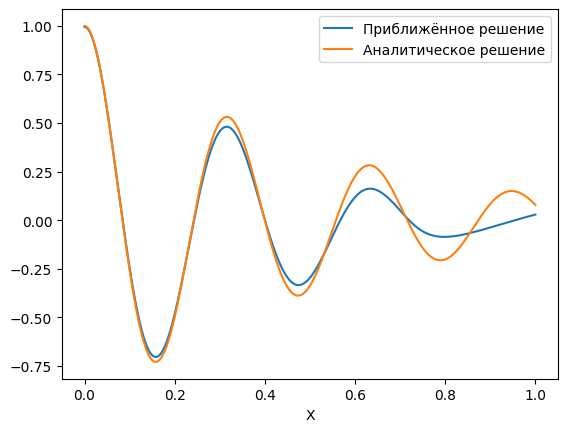

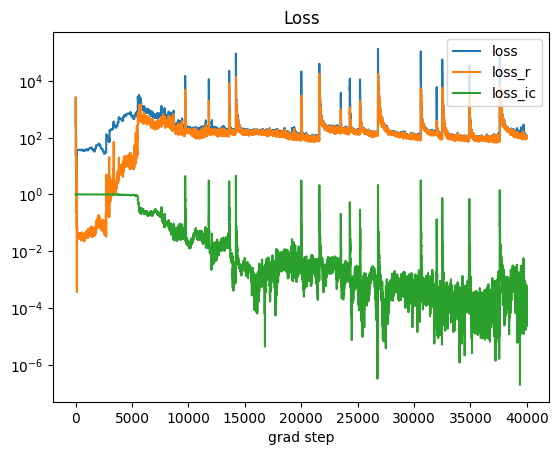

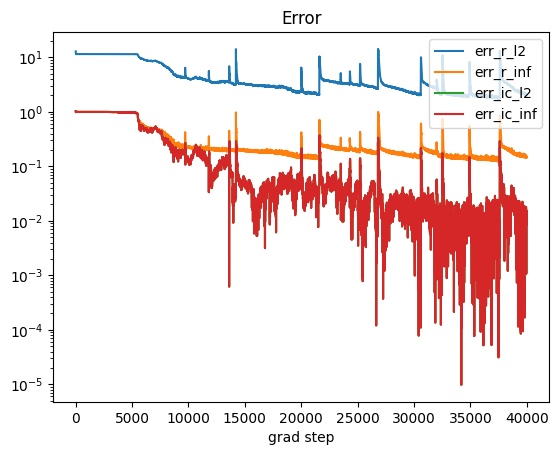

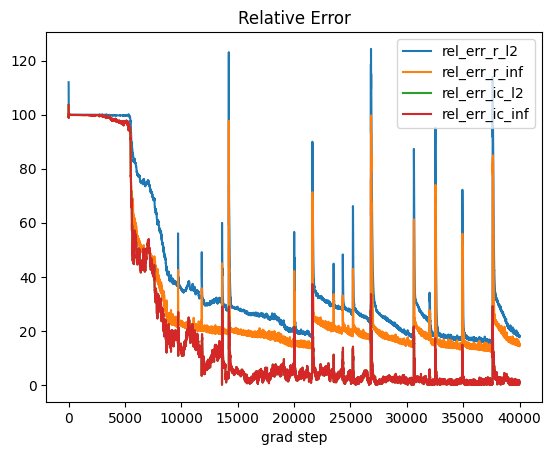

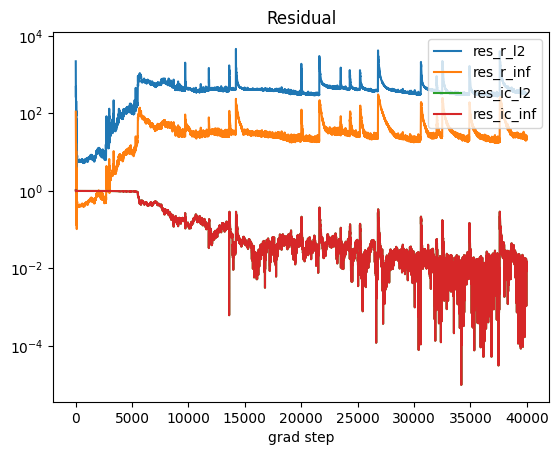

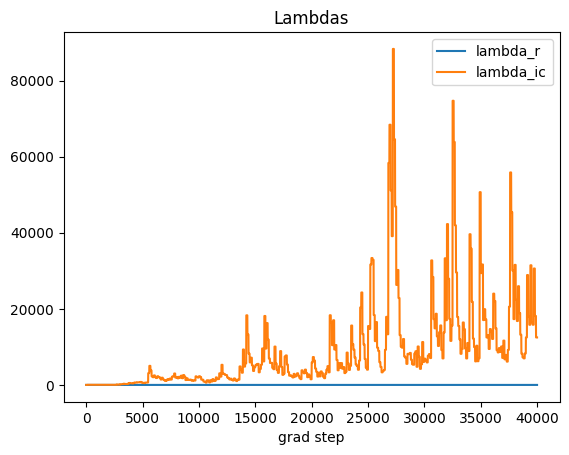

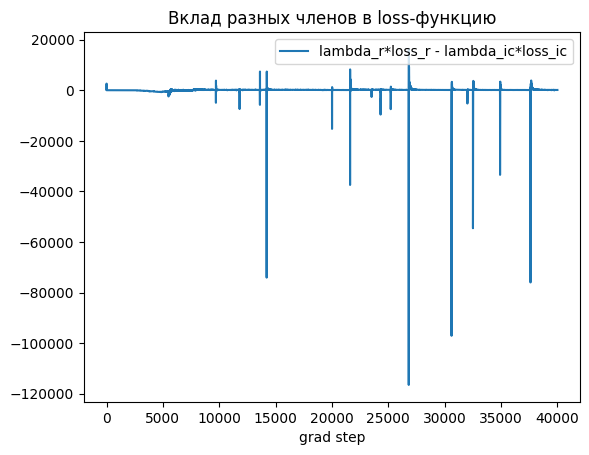

In [42]:
domain =  my_bvp.temporal_domain
u_exact = my_bvp.u_exact
n_train_points = training_params.n_train_points
batch_size =     training_params.batch_size
n_grad_steps =   training_params.n_epochs * (n_train_points // batch_size)
is_spatial = isinstance(my_bvp, ISpatial)
is_time_dependent = isinstance(my_bvp, ITemporal)

model = model.to('cpu')

with torch.no_grad():
    # Полученное решение
    x = torch.linspace(domain[0], domain[1], 1000).reshape(-1, 1)
    u_approx = model(x)
    plt.plot(x, u_approx, label="Приближённое решение")
    plt.plot(x, u_exact(x), label="Аналитическое решение")
    plt.xlabel("X")
    plt.legend(loc='upper right')
    plt.show()

    id = np.arange(0, n_grad_steps, n_train_points // batch_size)
    grad_steps_array = np.arange(1, n_grad_steps + 1)

    # Loss
    plt.semilogy(grad_steps_array[id], tm.data['loss'][id], label="loss")
    plt.semilogy(grad_steps_array[id], tm.data['loss_r'][id], label="loss_r")
    if is_spatial: plt.semilogy(grad_steps_array[id], tm.data['loss_bc'][id], label="loss_bc")
    if is_time_dependent: plt.semilogy(grad_steps_array[id], tm.data['loss_ic'][id], label="loss_ic")
    plt.title("Loss")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Error
    plt.semilogy(grad_steps_array[id], tm.data['err_r_l2'][id], label="err_r_l2")
    plt.semilogy(grad_steps_array[id], tm.data['err_r_inf'][id], label="err_r_inf")
    if is_spatial: plt.semilogy(grad_steps_array[id], tm.data['err_bc_l2'][id], label="err_bc_l2")
    if is_spatial: plt.semilogy(grad_steps_array[id], tm.data['err_bc_inf'][id], label="err_bc_inf")
    if is_time_dependent: plt.semilogy(grad_steps_array[id], tm.data['err_ic_l2'][id], label="err_ic_l2")
    if is_time_dependent: plt.semilogy(grad_steps_array[id], tm.data['err_ic_inf'][id], label="err_ic_inf")
    plt.title("Error")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Relative error
    plt.plot(grad_steps_array[id], tm.data['rel_err_r_l2'][id], label="rel_err_r_l2")
    plt.plot(grad_steps_array[id], tm.data['rel_err_r_inf'][id], label="rel_err_r_inf")
    if is_spatial: plt.plot(grad_steps_array[id], tm.data['rel_err_bc_l2'][id], label="rel_err_bc_l2")
    if is_spatial: plt.plot(grad_steps_array[id], tm.data['rel_err_bc_inf'][id], label="rel_err_bc_inf")
    if is_time_dependent:plt.plot(grad_steps_array[id], tm.data['rel_err_ic_l2'][id], label="rel_err_ic_l2")
    if is_time_dependent:plt.plot(grad_steps_array[id], tm.data['rel_err_ic_inf'][id], label="rel_err_ic_inf")
    plt.title("Relative Error")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Residual
    plt.semilogy(grad_steps_array[id], tm.data['res_r_l2'][id], label="res_r_l2")
    plt.semilogy(grad_steps_array[id], tm.data['res_r_inf'][id], label="res_r_inf")
    if is_spatial: plt.semilogy(grad_steps_array[id], tm.data['res_bc_l2'][id], label="res_bc_l2")
    if is_spatial: plt.semilogy(grad_steps_array[id], tm.data['res_bc_inf'][id], label="res_bc_inf")
    if is_time_dependent: plt.semilogy(grad_steps_array[id], tm.data['res_ic_l2'][id], label="res_ic_l2")
    if is_time_dependent: plt.semilogy(grad_steps_array[id], tm.data['res_ic_inf'][id], label="res_ic_inf")
    plt.title("Residual")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    # Lambdas
    plt.plot(grad_steps_array[id], tm.data['lambda_r'][id], label="lambda_r")
    if is_spatial: plt.plot(grad_steps_array[id], tm.data['lambda_bc'][id], label="lambda_bc")
    if is_time_dependent: plt.plot(grad_steps_array[id], tm.data['lambda_ic'][id], label="lambda_ic")
    plt.title("Lambdas")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()

    label = 'lambda_r*loss_r'
    tmp = tm.data['lambda_r'][id] * tm.data['loss_r'][id]
    if is_spatial:
        label += " - lambda_bc*loss_bc"
        tmp -= tm.data['lambda_bc'][id] * tm.data['loss_bc'][id]
    if is_time_dependent:
        label += " - lambda_ic*loss_ic"
        tmp -= tm.data['lambda_ic'][id] * tm.data['loss_ic'][id]
    plt.plot(grad_steps_array[id], tmp, label=label)
    plt.title("Вклад разных членов в loss-функцию")
    plt.xlabel("grad step")
    plt.legend(loc='upper right')
    plt.show()